# Введение в обработку естественного языка
# Урок 14. Transfer learning

# <font color='red'>Практическое задание</font>

__Задание__

1. Взять данные из<br>
https://www.kaggle.com/datasets/mrapplexz/bashim-quotes<br>
обучить модель GPT для генерации своих цитат 

_Это задача безусловной генерации текста. Для её решения подходит архитектура GPT._

2. Взять новостные данные из<br>
https://github.com/natasha/corus<br>
load_lenta2<br>
нам понадобиться сам текст и заголовок<br>
обучить модель T5 или GPT для генерации заголовков для статей

_Задача условной генерации текста. Для её решения подходит архитектура GPT или T5._

Выполнил ___Соковнин ИЛ___

In [56]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# <font color='red'>Задание 1</font>

1.1 Взять данные из<br>
https://www.kaggle.com/datasets/mrapplexz/bashim-quotes

# Reading the data

In [51]:
from google.colab import files

upload = files.upload()

Saving dataset.jsonl to dataset.jsonl


In [52]:
!ls -la

total 39612
drwxr-xr-x 1 root root     4096 Jul 14 10:32 .
drwxr-xr-x 1 root root     4096 Jul 14 07:26 ..
drwxr-xr-x 4 root root     4096 Jul  6 13:21 .config
-rw-r--r-- 1 root root 40531099 Jul 14 10:32 dataset.jsonl
drwxr-xr-x 5 root root     4096 Jul 14 07:33 gazeta
drwxr-xr-x 1 root root     4096 Jul  6 13:22 sample_data
-rw-r--r-- 1 root root     4659 Jul 14 08:25 tweets.txt


In [53]:
!mkdir data

In [54]:
!mv 'dataset.jsonl' 'data/dataset.jsonl'

In [57]:
DATASET_PATH = 'data/dataset.jsonl'

with open(DATASET_PATH) as f: # open the dataset file
    df = pd.read_json(DATASET_PATH, lines=True).set_index('id') # read the .jsonl file into Pandas DataFrame

In [58]:
print(df.dtypes)
# display(df)

date      datetime64[ns, UTC]
rating                float64
text                   object
dtype: object


In [59]:
df.head()

,date,rating,text
id,,,
1,2004-08-30 11:24:00+00:00,22010.0,"<Ares> ppdv, все юниксы очень дружелюбны.. они..."
2,2004-08-30 11:25:00+00:00,25105.0,<томатик_рад> а ты не чувствуешь красоту мира?...
3,2004-08-30 11:27:00+00:00,7192.0,"<Дор> ""мышка, почему у тебя такие большие глаз..."
4,2004-08-30 11:28:00+00:00,29169.0,"<PPDV[os2]> ""Мальчики, вы что больные, бегать ..."
5,2004-08-30 11:26:00+00:00,7140.0,<Ohtori_Akio> мы - как разработчики - живём с ...


# Visualizing the data

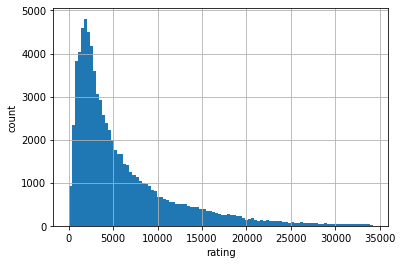

In [60]:
# plot rating histogram with outliers removed
rating = df.rating.dropna()
quantile = rating.quantile(.99)
rating.hist(bins=100, range=(rating.min(), quantile))
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

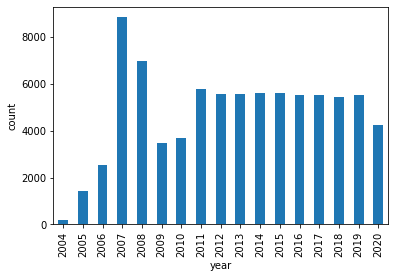

In [61]:
# plot quote count by year
by_year = df.groupby(df.date.dt.year)['text'].count()
by_year.plot.bar()
plt.xlabel('year')
plt.ylabel('count')
plt.show()

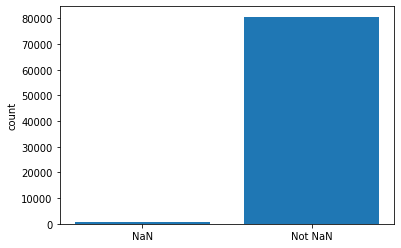

In [62]:
# plot count of NaN and not-NaN rated quotes
nans = df.rating.isna().sum()
not_nans = len(df) - nans


bars = [nans, not_nans]
y_pos = np.arange(len(bars))
plt.bar(y_pos, bars)
plt.xticks(y_pos, ('NaN', 'Not NaN'))
plt.ylabel('count')
plt.show()

In [63]:
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.width', 500)

In [64]:
# df['text'][0:5]
df['text'][2]

'<томатик_рад> а ты не чувствуешь красоту мира?\n<fox> честно говоря, я сейчас чувствую только отсутствие http.\n<томатик_рад> не туда смотришь, глянь вокруг!\n<fox> как я гляну, если http не работает? :/'


# <font color='red'>Задание 1</font>

<font color='blue'>1.2 Обучить модель GPT для генерации своих цитат</font>

_Это задача условной генерации текста. Для её решения подходит архитектура GPT._

Цита́та (от лат. citare, citatum — провозглашать, приводить) — дословная выдержка из какого-либо текста.

Обработка сообщений, генерируя из них цитаты.

In [65]:
# Загрузка твитов
!wget https://gist.githubusercontent.com/avidale/d3da0ded85a4a16db6eb84d8331638ce/raw/a188084e5ef37b43b01fef0534b55c865b9a569e/tweets.txt

--2022-07-14 10:34:14--  https://gist.githubusercontent.com/avidale/d3da0ded85a4a16db6eb84d8331638ce/raw/a188084e5ef37b43b01fef0534b55c865b9a569e/tweets.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4659 (4.5K) [text/plain]
Saving to: ‘tweets.txt.1’

tweets.txt.1        100%[===================>]   4.55K  --.-KB/s    in 0s      

2022-07-14 10:34:14 (70.5 MB/s) - ‘tweets.txt.1’ saved [4659/4659]



In [66]:
!ls

data  gazeta  sample_data  tweets.txt  tweets.txt.1


In [67]:
# Закачиваем сохранённые твиты
with open('tweets.txt', 'r') as f:
    tweets = f.read().strip().split('\n\n')
print(len(tweets))
for i in range(3):
    print(tweets[i])

26
Соловьев наконец-то вышел на новый уровень - теперь его стали банить и в офлайне
Дарим мы тебе бутылку игристого вина. Пить тебе еще рано, но встретиться с ней за некоторые преступления ты уже можешь. ПОЗ-ДРАВ-ЛЯ-ЕМ!
Да. Еще очень многие помнят, что такое госплан, как планировалось, талоны на еду, очереди, дефицит, выездные визы. Но спасибо, что напомнил


In [68]:
import torch
device = torch.device("cuda")

In [69]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [70]:
# Загружаем large GPT3, которая основана на GPT2
model_name = 'sberbank-ai/rugpt3large_based_on_gpt2'
#model_name = 'Grossmend/rudialogpt3_medium_based_on_gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/sberbank-ai/rugpt3large_based_on_gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3a4aea75af518e10b02aac733b25c92d979cec74d3b48edb877e13d5e4d4792f.aa4141df4e4cfca5435e8aa371aea7f575eb2d0767c1395e0d4cd6209796a705
Model config GPT2Config {
  "_name_or_path": "sberbank-ai/rugpt3large_based_on_gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 1536,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 2048,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weig

In [71]:
import random

In [72]:
# Мы хотим, чтобы GPT выводила суть, что после 3-х звёздочек ('***')
#  нужно генерировать какой то осмысленный текст похожий на твит.
# 
# Пишем рэндомное сэмплирование 5 твитов (берём 5 твитов из 26 случайным обазом)

sep = '\n***\n'  # Признак того, что твит закончился и нужногенерировать ещё один твит
# sep = '\n27479153	Sandy_mustache	2021-02-18 16:44:00	'


# Так как мы постоянно сэмплируем разные твиты,
# мы будем постоянно получать разное распределение
prefix = sep.join([''] + random.sample(tweets, k=5) + [''])

tokens = tokenizer(prefix, return_tensors='pt')
tokens = {k: v.to(model.device) for k, v in tokens.items()}
end_token_id = tokenizer.encode('***')[0]  # '***' - токен который будет оканчивать твит

# выводим то, что мы передаём на вход
print(prefix)


***
Дарим мы тебе бутылку игристого вина. Пить тебе еще рано, но встретиться с ней за некоторые преступления ты уже можешь. ПОЗ-ДРАВ-ЛЯ-ЕМ!
***
Соловьев наконец-то вышел на новый уровень - теперь его стали банить и в офлайне
***
Да. Еще очень многие помнят, что такое госплан, как планировалось, талоны на еду, очереди, дефицит, выездные визы. Но спасибо, что напомнил
***
Ну, с Михалковым все понятно. А для тех, кто тоже не различает понятия “Кооператив Озеро” и “Россия” еще раз напомним, что санкции предлагается вводить не против России, а против окружения Владимира Владимировича
***
А на такие случаи у нас припасена поправочка, принятая на пенечке - и вертели мы этот ЕСПЧ на нашей Конституции!
***



In [76]:
# Генерируем какой то осмысленный текст похожий на твит.

size = tokens['input_ids'].shape[1]
output = model.generate(
    **tokens, 
    #end_token=end_token_id,
    do_sample=False,  # вкл/выкл режим выдачи нескольких вариантов д.б. ещё один параметр
    max_length=size+128, 
    # max_length=size+64,
    repetition_penalty=4.2,  # штраф за повторы одинарных токенов
    temperature=0.7,  # температура
    num_beams=10,  # Строим дерево глубины 10
    # no_repeat_ngram_size=3  # ! тройки подряд идущих токенов не должны повторяться (3 и меньше токенов не должны повторяться)
)
decoded = tokenizer.decode(output[0])
result = decoded[len(prefix):]
print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Короче говоря, если вы думаете, что это шутка, то глубоко заблуждаетесь...
***
Уважаемые дамы и господа, напоминаем вам о том, что наша Конституция гарантирует каждому гражданину право на неприкосновенность частной жизни, личную и семейную тайну, защиту своей чести и доброго имени, возмещение государством вреда, причиненного незаконными действиями (бездействием) органов государственной власти или их должностных лиц, компенсацию морального вреда, причиненного неправомерными решениями и действиями (бездействием), нарушающими гражданские права и охраняемые законом интересы физических и юридических лиц, борьбу с любыми формами ограничения гражданских прав


In [77]:
# Генерируем какой то осмысленный текст похожий на твит.

size = tokens['input_ids'].shape[1]
output = model.generate(
    **tokens, 
    #end_token=end_token_id,
    do_sample=False, 
    max_length=size+128, 
    # max_length=size+64,
    repetition_penalty=4.2,   # штраф за повторы одинарных токенов
    temperature=1.3,  # температура
    num_beams=7,  # Строим дерево глубины 10
    no_repeat_ngram_size=5  # ! тройки подряд идущих токенов не должны повторяться (3 и меньше токенов не должны повторяться)
)
decoded = tokenizer.decode(output[0])
result = decoded[len(prefix):]
print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Оказывается, есть люди, которые считают, что Путин должен быть пожизненно лишен права баллотироваться на пост Президента Российской Федерации...
***
Удивительно, но факт: по данным опроса Левада-Центра, большинство россиян считает, что Владимир Путин должен остаться Президентом РФ до 2036 года
***
И это только то, что я узнал из открытых источников (в том числе от людей, которых знаю лично)
***
Надеюсь, вы понимаете, о чем идет речь?<s>
Мои твиты Чт, 12:51: RT @Sandy_mustache: https://t.co


__Вывод__

Источник сгенерированного текста в ответах узнаваем.
Сгененираванные последовательности имют определённый смысл.

# <font color='red'>Задание 2</font>

2.1 Взять новостные данные из https://github.com/natasha/corus<br>
load_lenta2<br>
нам понадобиться сам текст и заголовок<br>

2.2 обучить модель T5 или GPT для генерации заголовков для статей

_<font color='blue'>Задача условной генерации текста. Для её решения подходит архитектура GPT или T5.</font>_

#### По abstact сгенерировать заголовок статьи. Используем T5_trainer.ipynb

In [ ]:
!pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1
!pip install --upgrade datasets tqdm transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.9 MB/s 
     |████████████████████████████████| 8.2 MB 63.5 MB/s 
     |████████████████████████████████| 371 kB 58.8 MB/s 
  Created wheel for DAWG: filename=DAWG-0.8.0-cp37-cp37m-linux_x86_64.whl size=847809 sha256=e328d0e8db595cf2550e47765d64358ec8cfa4d721b374396b93bd5482c3a97a
  Stored in directory: /root/.cache/pip/wheels/85/51/a4/2de41ff197786537075027c27b479a38da92f50abc86634445
Successfully built DAWG
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 33.0 MB/s 
     |████████████████████████████████| 4.4 MB 65.7 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 140 kB 77.8 MB/s 
     |████████████████████████████████| 212 kB 71.9 MB/s 
     |████████████████████████████████| 1.1 MB 64.9

## Обучим модель на задачу суммаризации

In [ ]:
# !pip install datasets

In [ ]:
!ls

sample_data


In [ ]:
from datasets import load_dataset

dataset_train = load_dataset('IlyaGusev/gazeta', revision="v1.0", split= 'train[:10%]')
dataset_test = load_dataset('IlyaGusev/gazeta', revision="v1.0", split= 'test[:10%]')

No config specified, defaulting to: gazeta/default


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


No config specified, defaulting to: gazeta/default
Reusing dataset gazeta (/root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457)


In [ ]:
dataset_train

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 5240
})

In [ ]:
dataset_test

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 577
})

In [ ]:
dataset_test['summary'][0]

'В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.'

In [ ]:
dataset_test['title'][0]

'Венера, Ио или Тритон: куда полетит NASA'

In [ ]:
model_name = "IlyaGusev/rut5_base_sum_gazeta"

In [ ]:
def len_tok(text):
    return len(text.split())

In [ ]:
max_len_sum, max_len_tl = max(map(len_tok, dataset_train['summary'])), max(map(len_tok, dataset_train['title']))
max_len_sum, max_len_tl

(75, 18)

In [ ]:
max_len_sum, max_len_tl = 60, 15

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    tokenized_input = tokenizer(batch['summary'], padding='max_length', truncation=True, max_length=max_len_sum)
    tokenized_label = tokenizer(batch['title'], padding='max_length', truncation=True, max_length=max_len_tl)

    tokenized_input['labels'] = tokenized_label['input_ids']

    return tokenized_input

dataset_train = dataset_train.map(tokenize, batched=True, batch_size=8)
dataset_test = dataset_test.map(tokenize, batched=True, batch_size=8)

dataset_train.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])
dataset_test.set_format('numpy', columns=['input_ids', 'attention_mask', 'labels'])

Downloading:   0%|          | 0.00/279 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/808k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Parameter 'function'=<function tokenize at 0x7efcb0410ef0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/655 [00:00<?, ?ba/s]

  0%|          | 0/73 [00:00<?, ?ba/s]

In [ ]:
dataset_train.save_to_disk('gazeta/train')
dataset_test.save_to_disk('gazeta/test')

In [ ]:
!ls

gazeta	sample_data


In [ ]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments


model = T5ForConditionalGeneration.from_pretrained(model_name)

Downloading:   0%|          | 0.00/766 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/932M [00:00<?, ?B/s]

In [ ]:
output_dir = 'gazeta/output'

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_accumulation_steps=1, # Number of eval steps to keep in GPU (the higher, the mor vRAM used)
    prediction_loss_only=True, # If I need co compute only loss and not other metrics, setting this to true will use less RAM
    learning_rate=0.00001,
    evaluation_strategy='steps', # Run evaluation every eval_steps
    save_steps=1000, # How often to save a checkpoint
    save_total_limit=1, # Number of maximum checkpoints to save
    remove_unused_columns=True, # Removes useless columns from the dataset
    run_name='run_gazeta', # Wandb run name
    logging_steps=500, # How often to log loss to wandb
    eval_steps=500, # How often to run evaluation on the val_set
    logging_first_step=False, # Whether to log also the very first training step to wandb
    load_best_model_at_end=True, # Whether to load the best model found at each evaluation.
    metric_for_best_model="loss", # Use loss to evaluate best model.
    greater_is_better=False # Best model is the one with the lowest loss, not highest.
)

In [ ]:
%%time

# Обучение. У нас 10 эпох.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: url, text, title, date, summary. If url, text, title, date, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5240
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6550
/usr/local/lib/python3.7/dist-packages/transformers/data/data_collator.py:131: UserWarning: Creating a tensor from a list of numpy.ndarray

Step,Training Loss,Validation Loss
500,8.256800,3.326211
1000,4.611500,3.158144
1500,2.722300,3.000120
2000,2.582800,2.911969
2500,2.499100,2.876213
3000,2.460400,2.857541
3500,2.422100,2.833924
4000,2.444400,2.816941
4500,2.390900,2.806586
5000,2.401000,2.794934


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: url, text, title, date, summary. If url, text, title, date, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 577
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: url, text, title, date, summary. If url, text, title, date, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 577
  Batch size = 8
Saving model checkpoint to gazeta/output/checkpoint-1000
Configuration saved in gazeta/output/checkpoint-1000/config.json
Model weights saved in gazeta/output/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a 

CPU times: user 25min 50s, sys: 2min 10s, total: 28min 1s
Wall time: 29min 6s


In [ ]:
trainer.save_model(output_dir + '/model')

Saving model checkpoint to gazeta/output/model
Configuration saved in gazeta/output/model/config.json
Model weights saved in gazeta/output/model/pytorch_model.bin


In [ ]:
INX = 100
print("SUMMARY: | {}".format(dataset_test['summary'][INX]))
print("TITLE: | {}".format(dataset_test['title'][INX]))

SUMMARY: | Российские фрегаты «Адмирал Макаров» и «Адмирал Григорович» с крылатыми ракетами «Калибр-НК» проходят через турецкие проливы Босфор и Дарданеллы в направлении Средиземного моря. Ранее эти корабли уже участвовали в военной операции РФ в Сирии и теперь направляются туда на фоне обострившейся ситуации в Идлибе.
TITLE: | Снова в Сирию: российские фрегаты идут в Средиземное море


In [ ]:
device = "cuda"

In [ ]:
import torch

input_text = dataset_test['summary'][INX]

with torch.no_grad():
    tokenized_text = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

    source_ids = tokenized_text['input_ids'].to(device, dtype = torch.long)
    source_mask = tokenized_text['attention_mask'].to(device, dtype = torch.long)

    generated_ids = model.generate(
        input_ids = source_ids,
        attention_mask = source_mask, 
        max_length=512,
        num_beams=7,
        temperature = 1.3,  
        repetition_penalty=1, 
        length_penalty=1, 
        early_stopping=True,
        no_repeat_ngram_size=2  # количество повторов n-грамм > 2 запрещено.
    )

    # Параметры подбираются эксперементально

    pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

print("\noutput:\n" + pred)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



output:
«Адмирал Григорович» и «Калибр-НК»


In [ ]:
INX = 0
print("SUMMARY: | {}".format(dataset_test['summary'][INX]))
print("TITLE: | {}".format(dataset_test['title'][INX]))

input_text = dataset_test['summary'][INX]

with torch.no_grad():
    tokenized_text = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

    source_ids = tokenized_text['input_ids'].to(device, dtype = torch.long)
    source_mask = tokenized_text['attention_mask'].to(device, dtype = torch.long)

    generated_ids = model.generate(
        input_ids = source_ids,
        attention_mask = source_mask, 
        max_length=512,
        num_beams=7,
        temperature = 1.3,  
        repetition_penalty=1, 
        length_penalty=1, 
        early_stopping=True,
        no_repeat_ngram_size=2  # количество повторов n-грамм > 2 запрещено.
    )

    # Параметры подбираются эксперементально
    pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

print("\noutput:\n" + pred)

SUMMARY: | В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.
TITLE: | Венера, Ио или Тритон: куда полетит NASA

output:
Запущены четыре миссии


__Вывод__

Модель сформировала достаточно приемлемый заголовок.</br>

Правда во втором случае он сообщает о событии как о случившемся, хотя оно ещё не произошло.